# Pickup deep reinforcement learning problem with Policy gradients

## Description of the problem
This is my first attempt at doing reinforcement learning using vanilla deep learning with policy gradient . My goal here is to train an agent to pick-up points on a grid.

I called that situation : **the pickup problem**

I modelled a situation where an AI agent is placed on a grid without any information about his environment.
Random pick-up points are placed on the grid that the agent must pick to get a reward.


The model is simple and the rules are straightforward : 
- The agent would know nothing at the beginning except that if he goes off the grid, he loses and gets a punishment. 
- The agent would get a reward if he succeeds to pick-up a point. The reward will be proportional to the time elapsed to succeed to task, so that we reward the optimization of the task.




<img src="https://winblogs.azureedge.net/win/2015/12/desktop_01.png",width=50%>

#### Requirements
The script allow to use **only numpy and native python 2.7 for either creating a reinforcement learning environment and neural networks**. Thus making it easy to modify and tweak making it a comprehensive playground for beginners without any deep learning framework or GPU.

#### Why this model ?
This is a very simple model, but which can have real life applications (Uber, Postal Service, Food delivery, Games AI like PacMan)

#### Evolution of the model ?
- First, I will start by putting one pickup point on a grid
- Then, I want to make the point moving to see the strategies envisioned by the agent
- At last, I would like to put more than one point

### Summary : 
1. Defining the environment, the pickup points and the AI agent
2. Analyzing the problem with random walks
3. Creating a suitable Neural Network
4. Modelling a Pickup "Game" and the training of the agent
5. Battery of tests with different grid sizes and pickup points behavior

### Thanks : 
- Huge thanks to Andrej Karpathy and his blog post on RL  http://karpathy.github.io/2016/05/31/rl/, but I'll talk about that later
- The environment modelling is inspired on how the RL OpenAI Gym is implemented https://gym.openai.com/

### Note : 

**I am not expecting this script to be perfect, please comment and add your own adjustments**

***
## **1. Defining the environment, the pickup points and the AI agent**
In this section we will implement classes to define : 
- the grid environment
- the points (AI or pickup points)

##### What do we need ? 
Only numpy and random !

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

### Implementing the point class
A Point object in this problem will be either be the AI agent or a pickup point the agent is supposed to catch.

It is modelled by a position that can move (AI or pickup point) with or without a purpose (the AI's goal is to catch all the points). 

##### The moves : 
- limited to 5 : UP DOWN LEFT RIGHT or stay STILL (we'll talk more of staying still "movement" in next sections, the one where the pickup points move too)
- constraints by the boundaries of the grid
- can be a successful move (meaning for the AI that it has catch a pickup point)
- **If no moving function is set, the agent will take a random step. The goal here is to find that moving function with reinforcement learning** 
- The pickup points can be still or take random walks for now

In [2]:
class Point():
    def __init__(self,size=(8,8),moving = False,is_AI = False,no_positions = [],goal = [],position = None):
        '''INITIALIZATION
        A point is set on a predefined environment grid
        The position can be manually or randomly set
        One point can be either an AI or a pickup point
        '''
        self.size = size
        self.height,self.width = size
        if position == None:
            position = (random.randint(0,self.height-1),random.randint(0,self.width-1))
            while position in no_positions:
                position = (random.randint(0,self.height-1),random.randint(0,self.width-1))
        self.position = position
        self.x,self.y = self.position
        self.goal = goal
        self.moving = True if is_AI else moving 
        self.possible_moves = [(1,0),(-1,0),(0,1),(0,-1),(0,0)]
        self.value = 1 if is_AI else -1
        self.is_AI = is_AI
    
    def __repr__(self):
        '''PRINT METHOD'''
        return str(self.position)
    
    def __str__(self):
        '''PRINT METHOD'''
        return str(self.position)
    
    '''-----------------------------------------------------------------------------------------'''
    def set_position(self,new_position):
        '''To set a new position'''
        self.position = new_position
        self.x,self.y = self.position
        
    def set_goal(self,goal):
        '''To set a new goal'''
        self.goal = goal
        
    
    def move(self,action = None,impossible_positions = []):
        '''Move method, which will be called by an environment update'''
        if self.is_AI:
            '''Moves for the AI can be random or defined
            If the AI goes out of the environnement, the method returns False meaning it has lost the game. 
            If the AI reaches its goal of catching all the points, the method returns True meaning it has won the game.
            '''
            if action == None:
                default_action = random.choice(self.possible_moves)
                new_position = [sum(x) for x in zip(self.position,default_action)]
            else:
                new_position = [sum(x) for x in zip(self.position,action)]
                
            new_position = (new_position[0],new_position[1])
            self.set_position(new_position)
            if self.out_of_bounds():
                return False
            elif self.reach_goal():
                return True
            else:
                return None
            
        else:
            '''Moves for a point can be :
            - Random walk 
            - Random walk with the staying still possibility
            - No moves if no attributes are set
            '''
            if self.moving == "Random":
                new_position = self.random_move(impossible_positions)
                new_position = (new_position[0],new_position[1])
                self.set_position(new_position)
            elif self.moving == "Random still":
                new_position = self.random_move(impossible_positions,still = True)
                new_position = (new_position[0],new_position[1])
                self.set_position(new_position)
                
    def possible_position(self,position,impossible_positions):
        x,y = position
        if position in impossible_positions or x < 0 or y < 0 or x >= self.height or y >= self.width:
            return False
        else:
            return True
           
    '''-----------------------------------------------------------------------------------------'''
    '''PICKUP POINTS METHODS'''
    def random_move(self,impossible_positions = [],still = False):
        '''Random move method for a pickup point, returns no if no position is reachable
        if the parameter "still" is true, the point has the possibility of not moving and stay still in his choice
        '''
        possible_moves = self.possible_moves if still else [x for x in self.possible_moves if x != (0,0)]
        possible_positions = [tuple(sum(x) for x in zip(self.position,y)) for y in possible_moves]
        possible_positions = [x for x in possible_positions if self.possible_position(x,impossible_positions)]
        if len(possible_positions) > 0:
            return random.choice(possible_positions)
        else:
            return self.position
                
            
    '''-----------------------------------------------------------------------------------------'''
    '''AI AGENT METHODS'''
    def reach_goal(self):
        '''Returns True if the agent reaches his goal.
        This function has to be modified to implement multiple points'''
        if self.position in self.goal:
            return True
        else:
            return False
                
    def out_of_bounds(self):
        '''If the agent goes out of the environment returns False'''
        if self.x < 0 or self.y < 0 or self.x >= self.height or self.y >= self.width:
            return True
        else:
            return False
        

### Implementing the pickup problem environment
The environment is modelled by a grid on which can move the Points objects. 
An "update" call on the environment make all the Points move once. 
- If a move is successful, the AI agent would get a reward proportional to the number of time steps necessary to reach to goal
- If a move is an error (stepping out of the boundaries or on a impossible move) the AI agent would get a punishment
- If a move leads to nothing, obviously nothing happens and the simulation continue. 
- However, if the agents takes too long (gamma * environment height * environment width time steps) it loses. It avoids the agent to learn from a situation where it is trapped. I added this feature afterwards making my simulations more powerful, successful and fast. 

##### Reward modelling : 
The reward/punishment is inversely proportional to the time steps power two hyperparameters (either alpha or beta). 

It allows two things: 
- For a successful game (reward), to decrease the reward if the agent has taken too long, rewarding then the optimization of the task. (the importance of the decay is set by alpha)
- For an unsuccessful game (punishment), to weaken the punishment if the agent has "survived" longer, rewarding that it has not fallen out of the grid too quickly (the importance of this decay is set by beta)

Here again, this feature has been added afterwards and often leads to better results.

##### Initialization 
- A grid is created
- One pickup point ("O") is placed randomly on the grid (for now only one, and it does not move)
- The AI agent is placed ("X") randomly too with the purpose to catch the pickup point

In [3]:
class Pickup_env():
    def __init__(self,size=(8,8),pickup_points = None,n_points = 1,time_step = 1,render = False,render_update = False,AI_position = None,alpha = 0.5,beta = 0.5,gamma = 5):
        '''INTIALIZATION
        An environment has : 
        - A size (height and width)
        - A running time step count
        - A running turn count, defining if it's the AI or the points turn to move on the grid (1 for the AI and -1 for the points)
        - Hyperparameters for rewards/punishments decay alpha and beta, and for max time limit gamma
        - pickup points that are either randomly set or predefined
        - An AI agent
        - A model which is a matrix representing the environment grid where 0 is nothing, 1 the AI and -1 a pickup point
        - render attribute works with the _print method which only prints if render is true
        - render_update will be useful to watch a full episode of training the agent by showing every steps. 
        '''
        
        '''RENDERING OPTIONS'''
        self.render = render
        self.render_update = render_update
        
        self._print('>> Environment initialization')
        self.size = size
        self.height,self.width = size
        self.time_step = time_step
        self.turn = 1
        
        '''HYPERPARAMETERS'''
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.time_limit = self.gamma*(self.height+self.width)
        
        '''PICKUP POINTS'''
        if pickup_points == None:
            self._print('.. No Pickup points, setting one randomly which does not move') #to change for multiple points
            self.pickup_points = [Point(size = self.size,moving = False) for x in range(0,n_points)]
        else:
            self.pickup_points = pickup_points
        '''ENVIRONMENT MODEL'''
        self.model = np.zeros(self.size)
        self.are_pickup_points_moving = False
        
        for point in self.pickup_points:
            if self.are_pickup_points_moving or point.moving != False:
                self.are_pickup_points_moving = True        
            self.model[point.position] = point.value
            
        pickup_positions =  self.find_pickup_points()
        
        '''AI AGENT'''
        self.AI = Point(self.size,moving = True,is_AI = True,no_positions = pickup_positions,goal = pickup_positions,position = AI_position)
        self.model[self.AI.position] = self.AI.value
        self.all_points = self.pickup_points+[self.AI]
        

        
    '''-----------------------------------------------------------------------------------------'''
    def __repr__(self):
        '''CONVENIENT REPRESENTATION'''
        return str(self.model).replace(' 0.','. ').replace('-1.','O ').replace(' 1.','X ')
    
    def __str__(self):
        '''CONVENIENT REPRESENTATION'''
        return str(self.model).replace(' 0.','. ').replace('-1.','O ').replace(' 1.','X ')
    
    def _print(self,string):
        if self.render:
            print(string)
            
            
    '''-----------------------------------------------------------------------------------------'''
    '''ENVIRONMENT METHODS'''
    def find_pickup_points(self):
        '''Returns a list of tuples of all the pickup points positions'''
        return [x for x in zip(*[list(x) for x in np.where(self.model == -1)])]
    
    def find_all_points(self):
        '''Returns a list of tuples of all the pickup points and AI positions
        Helps to define the positions in where a pickup point cannot go
        '''
        return [x for x in zip(*[list(x) for x in np.where(self.model != 0)])]
    

    
    def update(self,action = None):
        '''UPDATE FUNCTION
        If the points are moving, an update calls one turn : 
        - First the AI move according to the defined action
        - Then another update call is needed to move the points
        Thus 2 updates are needed to finish a "turn" where everyone has moved
        Otherwise, one update call is enough to run a turn. 
        '''
                                                 
                                                 
        '''AI TURN'''
        if self.turn == 1:
            for point in [self.AI]:
                self.model[point.position] = 0
                move = point.move(action = action)
                #reward function must change to valorize time step when largely negative and penalize when largely positive
                if move == False:
                    self._print('Out of bounds')
                    return self.time_step,float(-1)/self.time_step**self.beta 
                elif move == True:
                    self._print('Pickup point !')
                    self.model[point.position] = point.value
                    self.pickup_points = [x for x in self.pickup_points if x.position != point.position]
                    return self.time_step,float(1)/self.time_step**self.alpha
                else:
                    self.model[point.position] = point.value
                    if self.time_step > self.time_limit:
                        return self.time_step,float(-1)/self.time_step**self.beta
                self.time_step = self.time_step + 1
                
                if self.are_pickup_points_moving: self.turn = -1
        else:
            '''PICKUP POINTS TURN'''
            for point in self.pickup_points:
                self.model[point.position] = 0
                point.move(impossible_positions = self.find_all_points())
                self.model[point.position] = point.value
            
            self.AI.set_goal(self.find_pickup_points())
            self.turn = 1
            
        


### Rendering
How does it look like ?

In [4]:
ENV = Pickup_env(size = (8,8),render = True)
ENV

>> Environment initialization
.. No Pickup points, setting one randomly which does not move


[[.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  O  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  X  .  . ]]

When we update, the agent will move. 

As we don't have yet any moving function, it will take a random step.

Obviously it does not reach its goal in one step, so the update returns "None" as a reward/punishment

In [5]:
a = ENV.update()
print(ENV)
print(a)

[[.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  O  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  X  .  . ]]
None


***
## **2. Analyzing the problem with random walks**

#### Random walk simulation
I am going to simulate the problem with the random steps moving function in order to observe the distribution of rewards and punishment.

This is often called a "random walk" problem. 
https://en.wikipedia.org/wiki/Random_walk

#### Definition of a game
A game will be defined as a full simulation of the problem where :
- An environment is initially set up
- The game goes on while the AI agent has not reach his goal of catching the pickup point. 
- The game will be characterized by the number of necessary time steps, and the reward that the AI got.

In [247]:
def random_simulation(size = (8,8)):
    environment = Pickup_env(size = size)
    update = environment.update()
    while update == None:
        update = environment.update()
    return update

def random_simulations(size = (8,8),n_simulations = 100):
    steps_necessary = []
    rewards = []
    for _ in range(n_simulations):
        output = random_simulation(size = size)
        steps_necessary += [output[0]]
        rewards += [output[1]]
    return steps_necessary,rewards

def plot_simulations(size = (8,8),n_simulations = 100):
    print('%s simulations on a %s environment' % (n_simulations,size))
    X,Y = random_simulations(size,n_simulations)
    plt.figure(figsize=(15,5))
    plt.title('Number of time steps to reach the pickup goal')
    plt.hist(X,bins = 20)
    plt.show()
    plt.figure(figsize=(15,5))
    plt.title('Distribution of rewards')
    plt.hist(Y,bins = 20)
    plt.show()

### Running simulations
I will simulate a hundred games with the random walk for different environment sizes : 

##### (8x8)
**Number of steps**
- Most simulations end before time 20. 
- Only about 5% go on for more than 50 time steps

**Reward**
- Most games get weak punishment (about 40%), meaning that the agent has wandered without losing or winning. 
- Quite many games get a strong punishment (about 20%), meaning that the agent has quickly lost by stepping out of the boundaries
- In only about 20% of the games the agent is winning. 

100 simulations on a (8, 8) environment


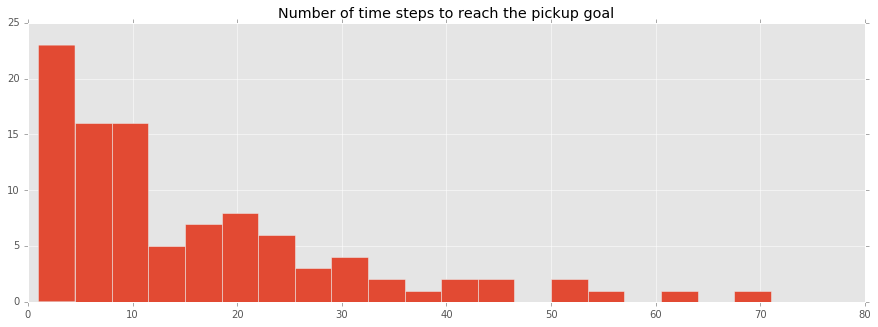

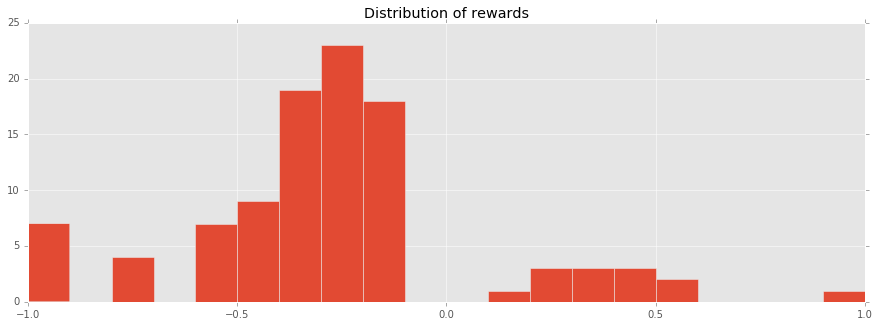

In [248]:
plot_simulations(size = (8,8))

##### (15x15)
In a bigger environment : 

**Number of steps**
- Obviously, the games last far longer

**Reward**
- Less agents have won (15%) but more get a weaker punishment (the environment is bigger, so the agent wanders longer)

100 simulations on a (15, 15) environment


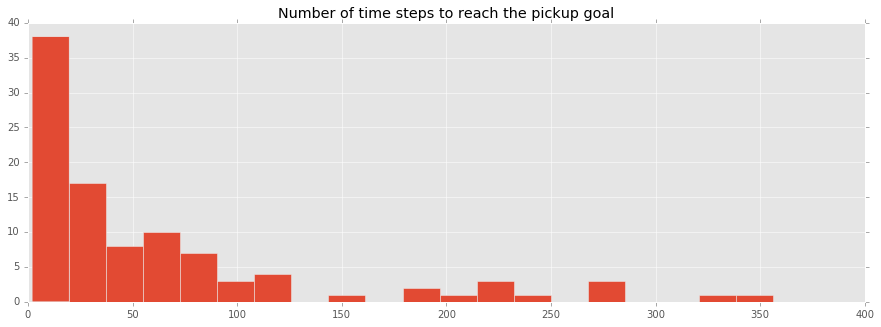

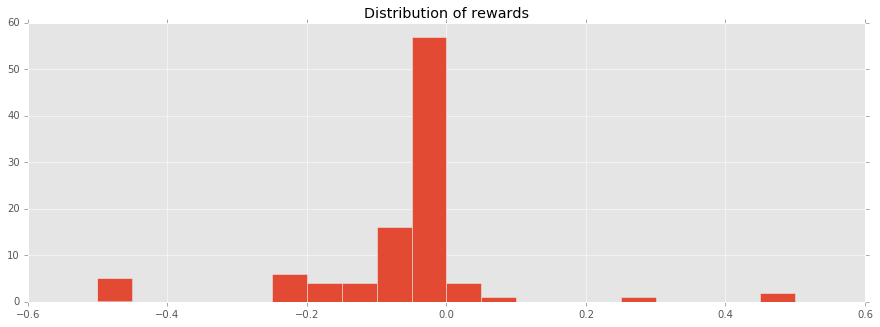

In [451]:
plot_simulations(size = (15,15))

##### (4x4)
In a smaller environment : 

**Number of steps**
- Obviously again, the games last less

**Reward**
- 25% of agents have won while a lot get a strong punishment

100 simulations on a (4, 4) environment


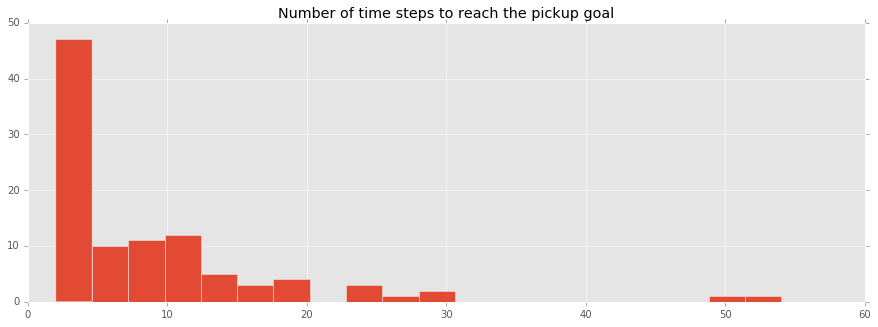

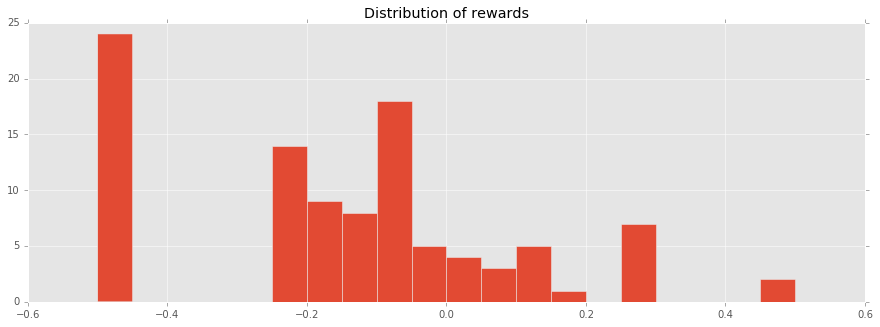

In [456]:
plot_simulations(size = (4,4))

***
## **3. Creating a suitable Neural Network**
#### Reinforcement learning with policy gradients
This part (creating a numpy vanilla neural network) and the following (training a reinforcement learning network) is genuinely inspired of Andrej Karpathy's oustanding work and post on reinforcement learning : 

http://karpathy.github.io/2016/05/31/rl/

https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5

The goal here is to implement the policy gradient using only numpy to compute Neural Networks


#### Changes with Karpathy's script 
Most functions are copied from Karpathy's script, except from : 
- We use a softmax classifier instead of just a sigmoid because we have multiple probabilities
- Every function is embedded in two classes, one for Neural Networks, one to model a game
- We are not computing the difference between frames as an input but one straigthforward frame of a game. The preprocessing is different too. 
- Of course, this has be adapted to fit with the environment model and not the OpenAI Gym environment even if I particularly took attention to keep the same formalism. 


In [6]:
import cPickle as pickle

class NeuralNetwork():
    def __init__(self,environment,H = 200,batch_size = 10,model = None):
        '''HYPERPARAMETERS'''
        self.H = H #number of hidden neurons
        self.batch_size = batch_size #every how many episodes to do a parameter update
        self.learning_rate = 1e-2
        self.gamma = 0.99 #discount factor for the reward
        self.decay_rate = 0.99 #decay factor for RMSprop leaky sum of grad^2
        #add resume and render ?
        
        self.environment = environment #loading the environment
        self.D = self.environment.width * self.environment.height
        
        '''CREATING A 2 LAYER NEURAL NETWORK'''
        if model != None:
            self.model = pickle.load(open(model+".p", 'rb'))
        else:
            self.model = {}
            self.model['W1'] = np.random.randn(self.H,self.D) / np.sqrt(self.D) # "Xavier" initialization
            self.model['W2'] = np.random.randn(5,self.H) / np.sqrt(self.H)
        
        self.grad_buffer = { k : np.zeros_like(v) for k,v in self.model.iteritems() } # update buffers that add up gradients over a batch
        self.rmsprop_cache = { k : np.zeros_like(v) for k,v in self.model.iteritems() } # rmsprop memory
    
    def load_model(self,model = "save"):
        self.model = pickle.load(open(model+".p", 'rb'))
    
    def set_learning_rate(self,learning_rate):
        self.learning_rate = learning_rate
        
    def sigmoid(self,x):
        return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]
    
    def softmax(self,x):
        x = x - np.max(x) #translating from the maximum to avoid overflow data and large number numeric approximation (more information in CS231n lecture 2)
        return np.exp(x)/np.sum(np.exp(x))
    
    def discount_rewards(self,r):
        """ take 1D float array of rewards and compute discounted reward """
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
            running_add = running_add * self.gamma + r[t]
            discounted_r[t] = running_add
        return discounted_r

    def policy_forward(self,x):
        h = np.dot(self.model['W1'], x)
        h[h<0] = 0 # ReLU nonlinearity
        logp = np.dot(self.model['W2'], h)
        p = self.softmax(logp)
        return p, h

    def policy_backward(self,eph, epdlogp,epx):
        """ backward pass. (eph is array of intermediate hidden states) """
        dW2 = np.dot(eph.T, epdlogp).T
        dh = np.dot(epdlogp, self.model['W2'])
        dh[eph <= 0] = 0 # backpro prelu
        dW1 = np.dot(dh.T, epx)
        return {'W1':dW1, 'W2':dW2}
    


***
## **4. Modelling a Pickup "Game" and the training of the agent**

In [7]:
class Game():
    def __init__(self,size = (8,8),pickup_points = None,AI_position = None,batch_size = 10,alpha = 0.5,beta = 0.5, gamma = 5):
        self.pickup_points = pickup_points
        self.AI_position = AI_position
        self.alpha,self.beta,self.gamma = alpha,beta,gamma
        self.parameters = {"alpha":self.alpha,"beta":self.beta,"gamma":self.gamma}
        self.env = Pickup_env(size = size,pickup_points = pickup_points,AI_position = AI_position,**self.parameters)
        self.NN = NeuralNetwork(self.env,batch_size = batch_size)
        self.prev_x = None
        self.xs,self.hs,self.dlogps,self.drs = [],[],[],[]
        self.running_reward = None
        self.reward_sum = 0
        self.episode_number = 0
        self.action = {(0,1):"RIGHT",(0,-1):"LEFT",(1,0):"DOWN",(-1,0):"UP",(0,0):"STILL"}
        
    def load_neural_network(self,NN):
        self.NN = NN
        
    def save_neural_network(self,model_name = "save"):
        pickle.dump(self.NN.model, open(model_name+".p", 'wb'))
        
    def preprocess(self):
        return self.env.model.astype(np.float).ravel()
    
    def sample_action(self,probabilities):
        possible_moves = self.env.AI.possible_moves
        choice = np.random.choice(5,p = np.array(probabilities))
        onehot_vector = np.zeros(5)
        onehot_vector[choice] = 1
        return possible_moves[choice],onehot_vector
        
    def run_step(self,show = False,record = True,render = False):
        if render:
            print(self.env)
            print('==> AI TURN')
            
        x = self.preprocess()
    
        # forward the policy network and sample an action from the returned probability
        probabilities, h = self.NN.policy_forward(x)
        action,onehot_vector = self.sample_action(probabilities)
        
        # record various intermediates (needed later for backprop)
        if record:
            self.xs.append(x) # observation
            self.hs.append(h) # hidden state
            self.dlogps.append(onehot_vector - probabilities) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)
        
        # step the environment and get new measurements
        update = self.env.update(action)
        done = False if update == None else True
        reward = 0 if update == None else update[1]
        if record:
            self.reward_sum += reward
            self.drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)
            
        if render: 
            print("> Action sampled in %s : %s - %s" % ([round(x,4) for x in probabilities],action,self.action[action]))
            print("")
            
        if self.env.turn == -1:
            if render:
                print(self.env)
                print('==> PICKUP POINTS TURN')
                print('')
            self.env.update()
            
            
        return done,reward,probabilities,action
    
    def run_episode(self,render = False,render_first = False,record = True):
        time_step = 1
        self.env = Pickup_env(size = self.env.size,pickup_points = self.pickup_points,AI_position = self.AI_position,**self.parameters)
        if render_first and time_step == 1: print(self.env)
        done,reward,probabilities,action = self.run_step(record = record,render = render)
        first = [probabilities,action]
        
        while done == False:
            time_step += 1
            done,reward,probabilities,action = self.run_step(record = record,render = render)
            
        if render: print(">>> Episode finished in %s time steps - reward : %f " % (time_step,reward) + ('' if reward < 0 else ' !!!!!!!!'))
        return done,reward,probabilities,action,first
            
            
    def train(self,render_first = False,n_episodes = 100000,intermediary_steps = 1000,saving_model = False):
        i = 0
        rewards = []
        all_rewards = []
        episodes_trained = 0
        if type(intermediary_steps) == int:
            intermediary_steps_render = intermediary_steps
            intermediary_steps_record = int(intermediary_steps/10)
        elif type(intermediary_steps) == tuple:
            intermediary_steps_render = intermediary_steps[0]
            intermediary_steps_record = intermediary_steps[1]

        while episodes_trained < n_episodes:
            done,reward,probabilities,action,first = self.run_episode(render_first = (render_first and (self.episode_number) % intermediary_steps_render == 0))
            self.episode_number += 1
            episodes_trained += 1
            
            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(self.xs)
            eph = np.vstack(self.hs)
            epdlogp = np.vstack(self.dlogps)
            epr = np.vstack(self.drs)
            self.xs,self.hs,self.dlogps,self.drs = [],[],[],[] # reset array memory
                    
            # compute the discounted reward backwards through time
            discounted_epr = self.NN.discount_rewards(epr)
            # standardize the rewards to be unit normal (helps control the gradient estimator variance)
            if sum(discounted_epr == 0) == len(discounted_epr):
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr /= np.std(discounted_epr)
    
            epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
            grad = self.NN.policy_backward(eph, epdlogp,epx)
            for k in self.NN.model: self.NN.grad_buffer[k] += grad[k] # accumulate grad over batch
            rewards.append(reward)
            if (self.episode_number) % intermediary_steps_render == 0:
                if render_first:
                    print("> First episode action sampled in %s : %s - %s" % ([round(x,4) for x in first[0]],first[1],self.action[first[1]]))
                print('>>> ep %d: game finished, reward: %.4f' % (self.episode_number, reward)) + ('' if reward < 0 else ' !!!!!!!!')
                if render_first: print('')
                    
            if (self.episode_number) % intermediary_steps_record == 0:
                all_rewards.append(sum(rewards)/intermediary_steps_record)
                rewards = []
                
            
            # perform rmsprop parameter update every batch_size episodes
            if self.episode_number % self.NN.batch_size == 0:
                for k,v in self.NN.model.iteritems():
                    g = self.NN.grad_buffer[k] # gradient
                    self.NN.rmsprop_cache[k] = self.NN.decay_rate * self.NN.rmsprop_cache[k] + (1 - self.NN.decay_rate) * g**2
                    self.NN.model[k] += self.NN.learning_rate * g / (np.sqrt(self.NN.rmsprop_cache[k]) + 1e-5)
                    self.NN.grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

            # boring book-keeping
            self.running_reward = self.reward_sum if self.running_reward is None else self.running_reward * 0.99 + self.reward_sum * 0.01
            if (saving_model and self.episode_number % intermediary_steps == 0): self.save_neural_network()
            self.reward_sum = 0
            self.env = Pickup_env(size = self.env.size,pickup_points = self.pickup_points,AI_position = self.AI_position,**self.parameters)
            #self.prev_x = None
        
        return all_rewards
        

    
    

##### Plotting rewards
We will use the following function to plot the rewards over training time, which will show us how well the agent is performing his task.

In [8]:
def plot_running_reward(rewards,training_episodes):
    plt.figure(figsize = (15,5))
    plt.title('Reward after %s training episodes' % training_episodes)
    plt.plot(rewards)
    plt.plot([0 for x in rewards])
    plt.show()

***
## **5. Battery of tests with different grid sizes and pickup points behavior**
In this part, I will try different situations to train the agent : 
1. A "Fixed" small game where the grid is 4x4 and the point and the AI are always at the same opposite corner. The point does not move. 
2. A Game where the grid is 8x8 and the point and AI are randomly placed at the beginning. The point does not move either. 
3. The same game as above, except that the grid is bigger (15x15)
4. A (8x8) game, same as (2), but with a moving point doing random walks. 

### 1. 4x4 "Fixed" game where the point and the AI are always at the same opposite corner. The point does not move. 

In [12]:
p = Point(size=(4,4),position = (3,3))
Fixed_game = Game(size = (4,4),pickup_points = [p],AI_position = (0,0),batch_size = 10)
Fixed_game.NN.set_learning_rate(1e-3)

In [13]:
Fixed_game.train(n_episodes = 400,intermediary_steps = (40,400),render_first = True,saving_model = False)

[[X  .  .  . ]
 [.  .  .  . ]
 [.  .  .  . ]
 [.  .  .  O ]]
> First episode action sampled in [0.2352, 0.1468, 0.3588, 0.1042, 0.1551] : (0, 0) - STILL
>>> ep 40: game finished, reward: -0.5000

[[X  .  .  . ]
 [.  .  .  . ]
 [.  .  .  . ]
 [.  .  .  O ]]
> First episode action sampled in [0.4109, 0.1069, 0.2741, 0.0902, 0.1179] : (-1, 0) - UP
>>> ep 80: game finished, reward: -1.0000

[[X  .  .  . ]
 [.  .  .  . ]
 [.  .  .  . ]
 [.  .  .  O ]]
> First episode action sampled in [0.4967, 0.0474, 0.3277, 0.0461, 0.0821] : (1, 0) - DOWN
>>> ep 120: game finished, reward: -0.3536

[[X  .  .  . ]
 [.  .  .  . ]
 [.  .  .  . ]
 [.  .  .  O ]]
> First episode action sampled in [0.4727, 0.0335, 0.3675, 0.0326, 0.0937] : (1, 0) - DOWN
>>> ep 160: game finished, reward: -0.3536

[[X  .  .  . ]
 [.  .  .  . ]
 [.  .  .  . ]
 [.  .  .  O ]]
> First episode action sampled in [0.5726, 0.0219, 0.3238, 0.0198, 0.0618] : (1, 0) - DOWN
>>> ep 200: game finished, reward: -0.4472

[[X  .  .  . ]
 [.  . 

[-0.15763369058949464]

In [14]:
Fixed_game.run_episode(render = True,record = False)

[[X  .  .  . ]
 [.  .  .  . ]
 [.  .  .  . ]
 [.  .  .  O ]]
==> AI TURN
> Action sampled in [0.5602, 0.0054, 0.3996, 0.0069, 0.0279] : (0, 1) - RIGHT

[[.  X  .  . ]
 [.  .  .  . ]
 [.  .  .  . ]
 [.  .  .  O ]]
==> AI TURN
> Action sampled in [0.6004, 0.0158, 0.3217, 0.0176, 0.0445] : (1, 0) - DOWN

[[.  .  .  . ]
 [.  X  .  . ]
 [.  .  .  . ]
 [.  .  .  O ]]
==> AI TURN
> Action sampled in [0.4253, 0.0193, 0.4647, 0.0279, 0.0628] : (0, 1) - RIGHT

[[.  .  .  . ]
 [.  .  X  . ]
 [.  .  .  . ]
 [.  .  .  O ]]
==> AI TURN
> Action sampled in [0.5493, 0.0148, 0.3711, 0.0187, 0.0462] : (0, 0) - STILL

[[.  .  .  . ]
 [.  .  X  . ]
 [.  .  .  . ]
 [.  .  .  O ]]
==> AI TURN
> Action sampled in [0.5493, 0.0148, 0.3711, 0.0187, 0.0462] : (0, 1) - RIGHT

[[.  .  .  . ]
 [.  .  .  X ]
 [.  .  .  . ]
 [.  .  .  O ]]
==> AI TURN
> Action sampled in [0.6991, 0.0194, 0.1992, 0.0259, 0.0564] : (1, 0) - DOWN

[[.  .  .  . ]
 [.  .  .  . ]
 [.  .  .  X ]
 [.  .  .  O ]]
==> AI TURN
> Action sampled 

(True,
 0.3779644730092272,
 array([ 0.83873852,  0.00643917,  0.10946452,  0.00990401,  0.03545378]),
 (1, 0),
 [array([ 0.560166  ,  0.00540759,  0.39958877,  0.00689221,  0.02794543]),
  (0, 1)])

### 2. 8x8 Game where  the point and AI are randomly placed at the beginning. The point does not move either. 

>>> ep 100: game finished, reward: -1.0000
>>> ep 200: game finished, reward: -0.1925
>>> ep 300: game finished, reward: -0.2357
>>> ep 400: game finished, reward: -0.2774
>>> ep 500: game finished, reward: -0.7071
>>> ep 600: game finished, reward: -0.1491
>>> ep 700: game finished, reward: -0.4472
>>> ep 800: game finished, reward: -0.3536
>>> ep 900: game finished, reward: -0.4082
>>> ep 1000: game finished, reward: -0.7071


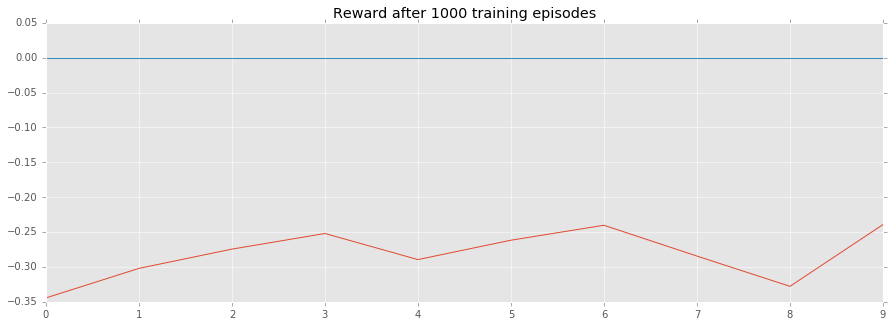

In [15]:
G = Game(size = (8,8))
G.NN.set_learning_rate(1e-3)
average_rewards = G.train(n_episodes = 1000,intermediary_steps = (100,100))
plot_running_reward(average_rewards,1000)

>>> ep 2000: game finished, reward: -0.4472
>>> ep 3000: game finished, reward: 0.1644 !!!!!!!!
>>> ep 4000: game finished, reward: -0.1111
>>> ep 5000: game finished, reward: -0.4472


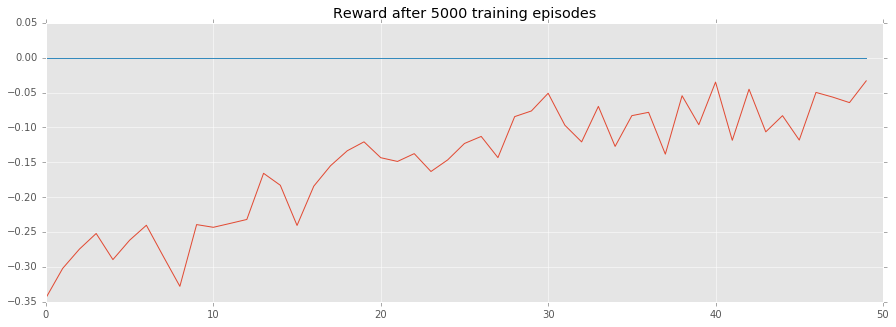

In [16]:
average_rewards += G.train(n_episodes = 4000,intermediary_steps = (1000,100))
plot_running_reward(average_rewards,5000)

>>> ep 6000: game finished, reward: 0.2182 !!!!!!!!
>>> ep 7000: game finished, reward: 0.1429 !!!!!!!!
>>> ep 8000: game finished, reward: 0.1459 !!!!!!!!
>>> ep 9000: game finished, reward: 0.3015 !!!!!!!!
>>> ep 10000: game finished, reward: 0.1925 !!!!!!!!
>>> ep 11000: game finished, reward: 0.5000 !!!!!!!!
>>> ep 12000: game finished, reward: 0.2673 !!!!!!!!
>>> ep 13000: game finished, reward: 0.1715 !!!!!!!!
>>> ep 14000: game finished, reward: 1.0000 !!!!!!!!
>>> ep 15000: game finished, reward: 0.2425 !!!!!!!!


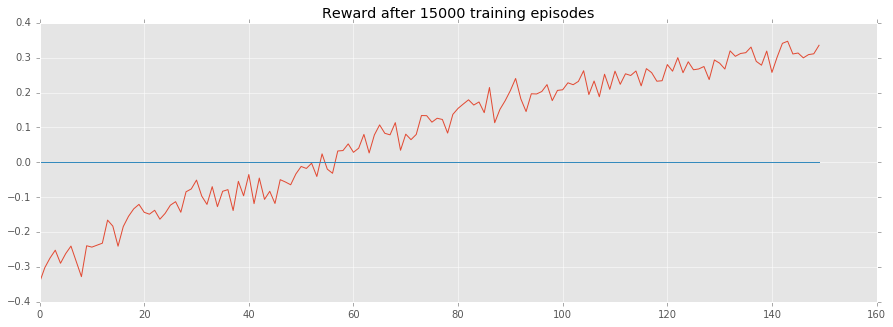

In [17]:
average_rewards += G.train(n_episodes = 10000,intermediary_steps = (1000,100))
plot_running_reward(average_rewards,15000)

In [18]:
G.run_episode(render = True,record = False)

[[.  .  .  .  .  .  .  . ]
 [.  .  .  .  X  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [O  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]]
==> AI TURN
> Action sampled in [0.3483, 0.0115, 0.0116, 0.5881, 0.0404] : (0, -1) - LEFT

[[.  .  .  .  .  .  .  . ]
 [.  .  .  X  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [O  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]]
==> AI TURN
> Action sampled in [0.6626, 0.0098, 0.0436, 0.2457, 0.0383] : (1, 0) - DOWN

[[.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  X  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [O  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]]
==> AI TURN
> Action sampled in [0.5792, 0.0106, 0.0454, 0.3222, 0.0427] : (1, 0) - DOWN

[[.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .

(True,
 0.3333333333333333,
 array([ 0.17868766,  0.12141797,  0.08106558,  0.5145814 ,  0.10424739]),
 (0, -1),
 [array([ 0.34832032,  0.01152507,  0.01164207,  0.58807574,  0.04043681]),
  (0, -1)])

### 3. 15x15 Game where  the point and AI are randomly placed at the beginning. The point does not move. 

>>> ep 1000: game finished, reward: -0.7192
>>> ep 2000: game finished, reward: -0.6548
>>> ep 3000: game finished, reward: -0.6227
>>> ep 4000: game finished, reward: -0.5927
>>> ep 5000: game finished, reward: -0.7071
>>> ep 6000: game finished, reward: 0.7533 !!!!!!!!
>>> ep 7000: game finished, reward: 0.6511 !!!!!!!!
>>> ep 8000: game finished, reward: 0.6114 !!!!!!!!
>>> ep 9000: game finished, reward: -0.6468
>>> ep 10000: game finished, reward: -0.8706


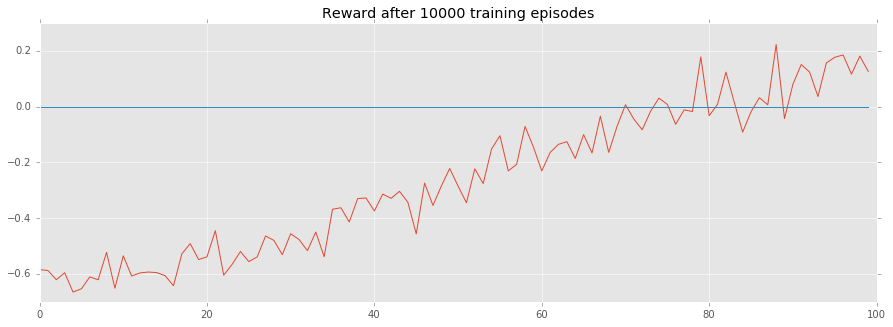

In [266]:
parameters = {"alpha":0.1,"beta":0.1,"gamma":10}
G = Game(size = (15,15),**parameters)
G.NN.set_learning_rate(1e-3)
average_rewards = G.train(n_episodes = 10000,intermediary_steps = (1000,100))
plot_running_reward(average_rewards,10000)

>>> ep 11000: game finished, reward: 0.7166 !!!!!!!!
>>> ep 12000: game finished, reward: -0.5651
>>> ep 13000: game finished, reward: -0.6244
>>> ep 14000: game finished, reward: 0.7449 !!!!!!!!
>>> ep 15000: game finished, reward: -0.5651
>>> ep 16000: game finished, reward: 0.6444 !!!!!!!!
>>> ep 17000: game finished, reward: 0.6663 !!!!!!!!
>>> ep 18000: game finished, reward: -0.5651
>>> ep 19000: game finished, reward: 0.7411 !!!!!!!!
>>> ep 20000: game finished, reward: -0.5651


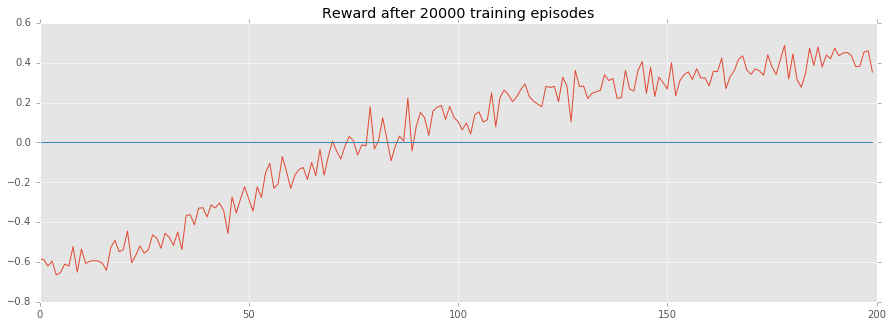

In [267]:
average_rewards += G.train(n_episodes = 10000,intermediary_steps=(1000,100))
plot_running_reward(average_rewards,20000)

>>> ep 21000: game finished, reward: -0.6619
>>> ep 22000: game finished, reward: 0.6558 !!!!!!!!
>>> ep 23000: game finished, reward: -0.5651
>>> ep 24000: game finished, reward: 0.6468 !!!!!!!!
>>> ep 25000: game finished, reward: 0.7049 !!!!!!!!
>>> ep 26000: game finished, reward: 0.6790 !!!!!!!!
>>> ep 27000: game finished, reward: 0.7490 !!!!!!!!
>>> ep 28000: game finished, reward: 0.6804 !!!!!!!!
>>> ep 29000: game finished, reward: 0.6663 !!!!!!!!
>>> ep 30000: game finished, reward: 0.7094 !!!!!!!!


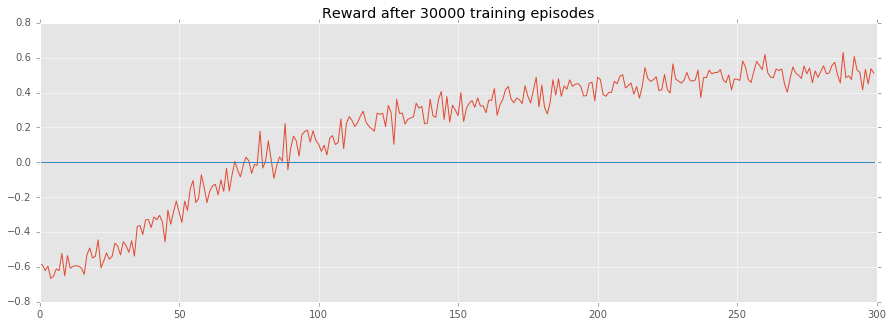

In [268]:
average_rewards += G.train(n_episodes = 10000,intermediary_steps=(1000,100))
plot_running_reward(average_rewards,30000)

In [269]:
G.run_episode(render = True,record = False)

[[.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [O  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  X  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]]
==> AI TURN
> Action sampled in [0.0059, 0.2428, 0.0041, 0.736, 0.0112] : (0, -1) - LEFT

[[.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  .  .  .  .  .  .  .  .

(True,
 0.693255844034287,
 [0.2407427167386772,
  0.14544987561616785,
  0.53733414977008287,
  0.018658594985810437,
  0.057814662889261674],
 (-1, 0),
 [[0.0058801302829608734,
   0.24281411849840698,
   0.0041028957988578016,
   0.73597129485901058,
   0.011231560560763802],
  (0, -1)])

### 4. 8x8 game with random initiliaztion, and **random walk model for pickup points**

In [270]:
parameters = {"alpha":0.1,"beta":0.1,"gamma":10}
p = Point(size=(8,8),moving = "Random")
G = Game(size = (8,8),pickup_points = [p],**parameters)
G.NN.set_learning_rate(1e-3)

>>> ep 1000: game finished, reward: -0.8232
>>> ep 2000: game finished, reward: 0.7449 !!!!!!!!
>>> ep 3000: game finished, reward: -0.6428
>>> ep 4000: game finished, reward: -0.8123
>>> ep 5000: game finished, reward: 0.6723 !!!!!!!!
>>> ep 6000: game finished, reward: 0.8513 !!!!!!!!
>>> ep 7000: game finished, reward: 0.7868 !!!!!!!!
>>> ep 8000: game finished, reward: 0.8706 !!!!!!!!
>>> ep 9000: game finished, reward: 0.6105 !!!!!!!!
>>> ep 10000: game finished, reward: 0.6105 !!!!!!!!


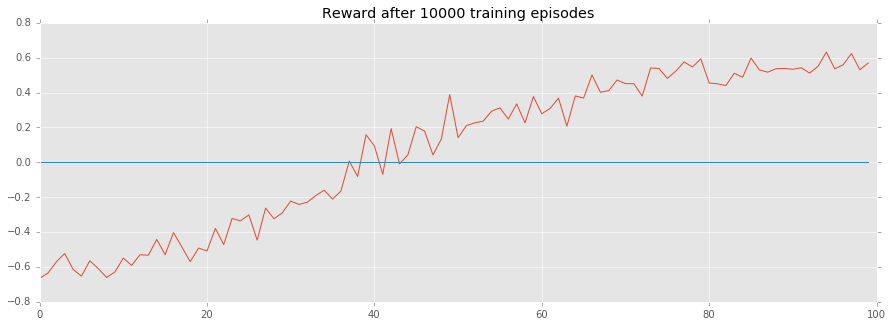

In [271]:
average_rewards = G.train(n_episodes = 10000,intermediary_steps=(1000,100))
plot_running_reward(average_rewards,10000)

>>> ep 11000: game finished, reward: 0.7490 !!!!!!!!
>>> ep 12000: game finished, reward: 0.7533 !!!!!!!!
>>> ep 13000: game finished, reward: 0.7248 !!!!!!!!
>>> ep 14000: game finished, reward: 0.6988 !!!!!!!!
>>> ep 15000: game finished, reward: -0.8960
>>> ep 16000: game finished, reward: 0.7533 !!!!!!!!
>>> ep 17000: game finished, reward: 0.6376 !!!!!!!!
>>> ep 18000: game finished, reward: 0.7680 !!!!!!!!
>>> ep 19000: game finished, reward: 0.6849 !!!!!!!!
>>> ep 20000: game finished, reward: 0.8960 !!!!!!!!


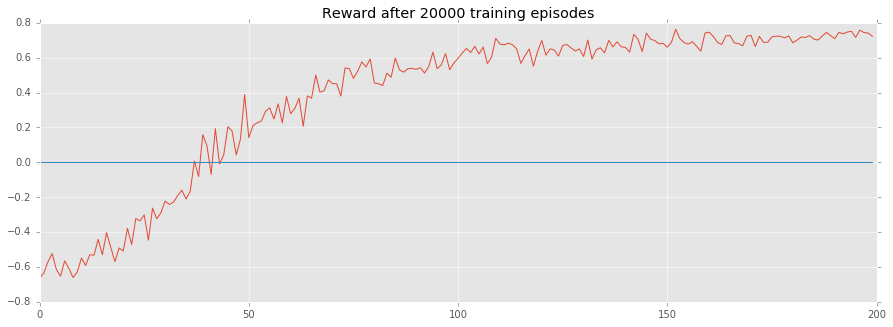

In [272]:
average_rewards += G.train(n_episodes = 10000,intermediary_steps=(1000,100))
plot_running_reward(average_rewards,20000)

>>> ep 21000: game finished, reward: 0.8027 !!!!!!!!
>>> ep 22000: game finished, reward: 0.7800 !!!!!!!!
>>> ep 23000: game finished, reward: 0.7533 !!!!!!!!
>>> ep 24000: game finished, reward: 0.7943 !!!!!!!!
>>> ep 25000: game finished, reward: 0.7449 !!!!!!!!
>>> ep 26000: game finished, reward: 0.8027 !!!!!!!!
>>> ep 27000: game finished, reward: 0.6933 !!!!!!!!
>>> ep 28000: game finished, reward: 0.7248 !!!!!!!!
>>> ep 29000: game finished, reward: 0.7071 !!!!!!!!
>>> ep 30000: game finished, reward: 0.7166 !!!!!!!!


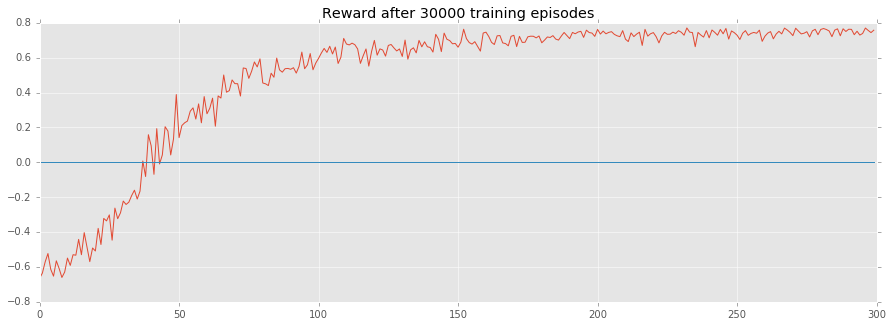

In [273]:
average_rewards += G.train(n_episodes = 10000,intermediary_steps=(1000,100))
plot_running_reward(average_rewards,30000)

>>> ep 31000: game finished, reward: 0.8123 !!!!!!!!
>>> ep 32000: game finished, reward: 0.7943 !!!!!!!!
>>> ep 33000: game finished, reward: 0.8027 !!!!!!!!
>>> ep 34000: game finished, reward: 0.7868 !!!!!!!!
>>> ep 35000: game finished, reward: 0.7449 !!!!!!!!
>>> ep 36000: game finished, reward: 1.0000 !!!!!!!!
>>> ep 37000: game finished, reward: 0.7738 !!!!!!!!
>>> ep 38000: game finished, reward: 0.9330 !!!!!!!!
>>> ep 39000: game finished, reward: 0.7449 !!!!!!!!
>>> ep 40000: game finished, reward: 0.7680 !!!!!!!!


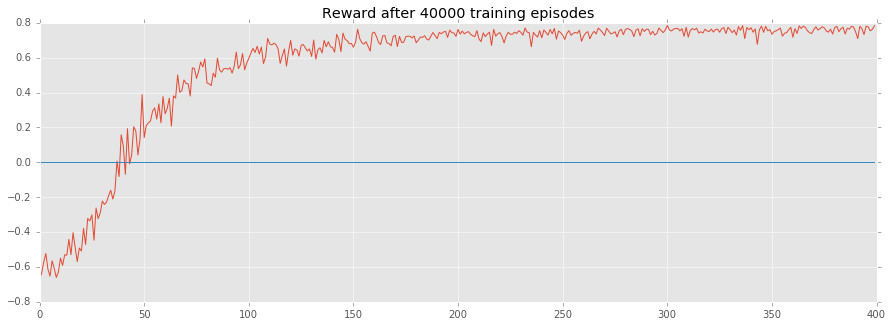

In [274]:
average_rewards += G.train(n_episodes = 10000,intermediary_steps=(1000,100))
plot_running_reward(average_rewards,40000)

In [275]:
G.run_episode(render = True,record = False)

[[.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  O  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  X  .  .  . ]]
==> AI TURN
> Action sampled in [0.0, 0.982, 0.0113, 0.0018, 0.0049] : (-1, 0) - UP

[[.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  O  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  X  .  .  . ]
 [.  .  .  .  .  .  .  . ]]
==> PICKUP POINTS TURN

[[.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  O  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  X  .  .  . ]
 [.  .  .  .  .  .  .  . ]]
==> AI TURN
> Action sampled in [0.0005, 0.6356, 0.0037, 0.2277, 0.1325] : (0, -1) - LEFT

[[.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  O  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  

(True,
 0.8513399225207846,
 [0.27075282970124021,
  0.17070061480539159,
  0.21250852443854173,
  0.21793263281778413,
  0.12810539823704239],
 (-1, 0),
 [[9.6307303224222388e-06,
   0.98203377854228058,
   0.01129886887371526,
   0.0017691285940913935,
   0.0048885932595903233],
  (-1, 0)])

In [279]:
G.run_episode(render = True,record = False)

[[.  .  .  .  .  .  O  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  X  .  . ]]
==> AI TURN
> Action sampled in [0.0, 0.9762, 0.0008, 0.0024, 0.0206] : (-1, 0) - UP

[[.  .  .  .  .  .  O  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  X  .  . ]
 [.  .  .  .  .  .  .  . ]]
==> PICKUP POINTS TURN

[[.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  O  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  X  .  . ]
 [.  .  .  .  .  .  .  . ]]
==> AI TURN
> Action sampled in [0.0003, 0.7535, 0.0848, 0.0052, 0.1563] : (-1, 0) - UP

[[.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  O  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .  .  .  . ]
 [.  .  .  .  .

(True,
 0.7943282347242815,
 [0.017932112763234236,
  0.60316073126276137,
  0.082911292642868492,
  0.071663895027008845,
  0.22433196830412694],
 (-1, 0),
 [[9.9837523203644061e-07,
   0.97619805395922865,
   0.00081764035761785158,
   0.0023846609997033711,
   0.020598646308218251],
  (-1, 0)])

***
## Conclusion, next steps and what to expect soon

#### Quick conclusion
For now the results are quite nice, showing multiple steps in the training of an AI agent : 
1. First the AI automatically learns to avoid going out of the grid
2. Then he learns to catch the point by going straight to it
3. When the point is moving (and this is becoming interesting), he starts to elaborate strategies to more efficiently catch the point, by sometimes waiting for the point instead of rushing to a situation where the point has always a move ahead

#### Next steps
1. Probably refine everything to add comments everywhere and clean the code
2. Determine better hyperparameters or reward/environment modelling. It works quite well but it could really be optimized
3. Add the possibility to have multiple points
4. Add new moves for the pickup points, a "runaway" move to see what strategy would the AI adopt to chase the points, and a "regular" move where the points turn in circle (or more accurately a square
5. Translate the deep learning part to a more robust framework, probably Tensorflow and Keras
6. Use the framework to develop more complicated model with Convolutional Neural Networks (which I think would allow to pre-train an agent on any grid size)
